<h1 style='text-align:center'>Adivina el Personaje usando Visión por Computadora</h1>

<p>Hace algún tiempo el historiador Christian Nader propuso un desafío en redes sociales que consistía en identificar la mayor cantidad de personajes históricos en una fotografía (ver portada). Pensé que sería una oportunidad para aplicar algunas técnicas de manipulación de imágenes con Python, así como también sería un buen momento para aprender a realizar búsqueda inversa de imágenes de manera programática. Esto último no es más que cargar una imagen cualquiera en un buscador de internet para averiguar de quien o de que se trata.</p>
<p>El proceso en general es bastante simple: identificar rostros dentro de la imagen, recortarlos, guardarlos en un archivo y luego subir ese mismo archivo al buscador para saber de quien se trata. 
Para la manipulación de imágenes usaremos el paquete Open CV. Por otra parte, para las búsquedas en internet usaremos requests y beautifulSoup. También usaremos translate para traducir los resultados de las búsquedas al español. Adicionalmente, usaremos otros paquetes para la manipulación de archivos y estructuras de datos.
</p>

<h2>Procedimiento</h2>
<p>Comenzaremos con la importación de los paquetes necesarios, como detallamos al inicio. Nótese que haremos uso del comando %matplotlib inline para observar las imágenes dentro del notebook. Para el mismo propósito, en la línea siguiente especificamos las dimensiones que tendran las visualizaciones de nuestras imágenes.</p>

In [18]:
import cv2
import json
import requests
from  matplotlib import pyplot as plt
from bs4 import BeautifulSoup
from translatepy.translators.google import GoogleTranslate
import numpy as np
import tempfile
%matplotlib inline
plt.rcParams["figure.figsize"] = (12,11)

<h2>Manipulación de imágenes</h2>
<p>Uno de los aspectos que torna sumamente práctico el desarrollo y análisis de datos con Python es la existencia de paquetes especializados, compartidos generosamente por sus creadores, que se encargan de realizar el trabajo pesado y de esa manera permitir a los usuarios entrar directamente al análisis. Este es el caso del paquete Open CV, que facilita la detección de objetos en imágenes (en nuestro caso rostros) haciendo uso de algoritmos de machine learning pre-entrenados. 
Iniciaremos por leer la imagen de los rostros de personajes históricos así como el archivo que contiene el modelo de clasificación de objetos (haar cascades). A continuación vamos a pasar la imagen a escala de grises, esto último en consideración de los requerimientos del algoritmo de clasificación.</p>

<p>El siguiente paso es usar el clasificardor para detectar los rostros en la imagen de personajes históricos. Tal como lo señalé, los paquetes especializados tornan el análisis mucho más simple. Sin embargo, el trabajo que hacen las funciones es bastante complejo y profundo. En este caso en particular, recomiendo la leer este blog para una explicación detallada de lo que sucede tras bambalinas.
Los parámetros que vamos a especificar son, a más de la imágen, el porcentaje de reducción de la imágen para las búsquedas consecutivas, la cantidad mínima de imágenes descartadas que limitarán la existencia de un rostro, y finalmente la dimensión del cuadrado que enmarcará los rostros (en pixeles). Con los parámetros utilizados, no se logra detectar todos los rostros, así que se pueden probar diferentes valores para obtener mejores resultados.
</p>

In [34]:
imagePath = 'personajes.jpeg'
cascPath = 'haarcascade_frontalface_default.xml'
faceCascade = cv2.CascadeClassifier(cascPath)
image = cv2.imread(imagePath)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor=1.01,
    minNeighbors=3,
    minSize=(20, 20)
)
print("Se encontraron {0} rostros!".format(len(faces)))

Se encontraron 108 rostros!


<p>Lo que sigue es visualizar los rostros que fueron encontrados. Dado que la variable ‘faces’ es del tipo ‘np.array’ podemos usar la vectorización en lugar de control de flujo (for loop) para procesar los rostros usando el método ‘rectangle’ del paquete cv2. Debemos especificar la ubicación de los vértices de cada cuadrado y la extensión, la escala RGB y el grosor de la línea del rectángulo.</p>

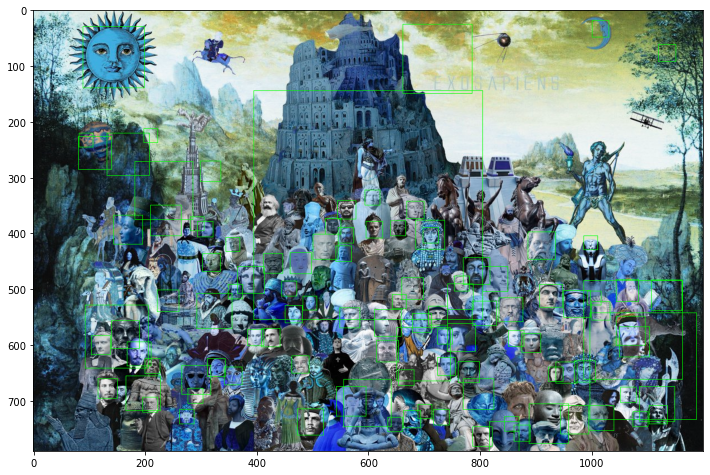

In [3]:
def rectangulo(a):
    cv2.rectangle(image, (a[0], a[1]), (a[0]+ a[2], a[1] + a[3]), (0, 255, 0), 1)

np.apply_along_axis(rectangulo, 1, faces)

plt.imshow(image)

<h3>Búsqueda Inversa de Imágenes</h3>
<p>A continuación vamos recortar los rostros de la imagen, guardarlos en un archivo temporal y cargarlos en el buscador para saber de quien se trata.</p>

<p>Muchos de los buscadores de internet ofrecen la posibilidad de cargar una imagen para averiguar de que se trata. A ese procedimiento se lo conoce como búsqueda inversa de imágenes.
Por su popularidad, la primera alternativa que se viene a la mente es Google, sin embargo, varios foros especializados señalan que el buscador Yandex arroja mejores y más comprensibles resultados.</p>

<p>En este punto es importante hacer una puntualización. Muchas páginas web, en su justo derecho, limitan las conexiones realizadas de manera programática, entre otras razones, para evitar la saturación de sus servidores. Este es el caso de Yandex, que cuando intenté buscar todas las imágenes al mismo tiempo, interpuso un requerimiento de autenticación (captcha) que debía ser completado manualmente. Por ese motivo el siguiente fragmento del código de programación se aplicará a una imagen únicamente, pese a que resultaría más conveniente insertarlo en la función ‘recorte’ para gestionarlo de manera vectorizada.</p>

<p>Usaremos el paquete ‘requests’ para realizar una petición al servidor de Yandex, que equivale a cargar el archivo manualmente. Debemos especificar los parámetros de la búsqueda que comprendeb el servicio que requerimos (‘imagesearch’), el formato de la respuesta (‘json’) y el nombre del formulario donde subiremos la imagen (‘b-page_type_search-by-image__link’). 
Una vez que obtuvimos la respuesta, procesaremos la misma con el paquete ‘json’ y buscaremos la ‘url’ del resultado.</p>

<p>Posteriormente usaremos esa ‘url’ para solicitar a Yandex el contenido de la respuesta (que incluye el nombre del personaje histórico), valiéndonos otra vez del paquete ‘requests’.</p>

In [4]:
def recorte(a, searchUrl, params):
    roi_color = image[a[1]: a[1] + a[3], a[0]: a[0] + a[2]]
    try: 
        target = tempfile.NamedTemporaryFile(suffix='.jpg')
        cv2.imwrite(target.name, roi_color)
        files = {'upfile': ('blob', target, 'image/jpeg')}
        response = requests.post(searchUrl, params=params, files=files)
    finally:
        target.close()
    query_string = json.loads(response.content)['blocks'][0]['params']['url']
    img_search_url= searchUrl + '?' + query_string
    soup = BeautifulSoup(requests.get(img_search_url).text, 'lxml')
    quien = [x.text for x in soup.find_all(name='span', attrs={'class': 'Button2-Text'})]
    return quien

In [52]:
prueba = faces[71 , :] #seleccionar una imagen entre las 108 encontradas

In [53]:
searchUrl = 'https://yandex.com/images/search'
params = {'rpt': 'imageview', 'lang':'en','format': 'json', 'request': '{"blocks":[{"block":"b-page_type_search-by-image__link"}]}'}

quien = np.apply_along_axis(lambda x: recorte(x, searchUrl, params), 0, prueba)
print(quien)

['600×600' '300×300' '96×120' '100×100' '50×50' '48×48' 'юстиниан i'
 'юстиниан джессап' 'император юстиниан икона'
 'юстиниан император биография' 'заслуги императора юстиниана'
 'Similar images']


<p>Al revisar la respuesta, se aprecia que el resultado está escrito en Ruso, así que echaremos mano del paquete ‘translatepy’ para traducir los resultados (en este caso al inglés). En vista de que los resultados están albergados dentro de una lista, usaremos la función ‘map’ en lugar de control de flujo (‘for loop’) como otro ejemplo de vectorización.</p>

In [54]:
gtranslate = GoogleTranslate()
personajes = map(lambda x: gtranslate.translate(x, 'eng').result, quien)
list(personajes)

['600×600',
 '300×300',
 '96×120',
 '100×100',
 '50×50',
 '48×48',
 'Justinian I',
 'Justinian Jessap',
 'Emperor Justinian Icon',
 'Justinian Emperor Biography',
 'Merit Emperor Yustiniana',
 'Similar images']